# Clustering

This notebook contains all clustering experiments.

It provides the geolocation clustering visualisation in the __geospaital analysis__ section as well as some preliminary experiments which gave insight into hypotheses to be tested

## Packages
Importing all necessary packages to run the notebook

In [15]:
# data handling and manipulation
from pathlib import Path
import pandas as pd

# clustering
from sklearn.cluster import KMeans

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

## Directory navigation and creation
Creating pathlib.Path objects for cross-platform navigation and loading the three datasets into pandas DataFrame objects

**Note:** here we import the cleaned accidents.pkl file

In [25]:
# creating Path object for current working directory
cwd = Path('./')
root = cwd.resolve().parent
# creating Path object for additional data directory
additional_data_dir = root / 'additional_data'
# create new directory for additional data
Path(additional_data_dir).mkdir(exist_ok=True)

# creating Path object for plots directroy
plots_dir = root / 'plots'
# create new directory for plots
Path(plots_dir).mkdir(exist_ok=True)

# defining the directory to original data
data_dir = root / 'data'
additional_directory = root / 'additional_data'

# list the .csv files for the project
for file in data_dir.glob('*.csv'):
    print(file)
    
# reading in .csv files to dataframes
vehicles = pd.read_csv(data_dir / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(data_dir / 'casualties2019.csv', dtype={'Accident_Index': str})
# cleaned accidents DataFrame
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents.head(5)

/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/accidents2019.csv
/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/casualties2019.csv
/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/vehicles2019.csv


,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,lsoa_of_accident_location,district,converted_date,converted_time,sunrise,sunset,day_length,datetime,decimal_time,day_of_year
0,2019010128300,-0.153842,51.508057,1,3,2,3,2,1,E09000033,...,E01004762,westminster,2019-02-18,17:50:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 17:50:00,17.833333,49
1,2019010164251,-0.141154,51.502191,1,3,1,2,2,1,E09000033,...,E01004736,westminster,2019-02-18,18:50:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 18:50:00,18.833333,49
2,2019010164259,-0.174097,51.527663,1,3,2,1,2,1,E09000033,...,E01004728,westminster,2019-02-18,23:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 23:00:00,23.000000,49
3,2019010164414,-0.163973,51.515931,1,3,2,1,2,1,E09000033,...,E01004658,westminster,2019-02-18,02:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 02:00:00,2.000000,49
4,2019010164107,-0.103521,51.464277,1,3,1,1,2,9,E09000022,...,E01003051,lambeth,2019-02-18,08:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 08:00:00,8.000000,49


In [8]:
accidents.shape

(117536, 37)

## Clustering on location

The first experiment is to cluster using the longitude and latitude features

In [9]:
# extract coordinate data from the accident dataframe
coords = accidents.filter(['longitude', 'latitude'])
coords.head(5)

# analysing kmeans clustering for different number of clusters
inertias = {}

# loop through different values of k for k-means clustering
for i in range(2, 26):
    km = KMeans(n_clusters=i)
    fit = km.fit(coords)
    inertias[i] = fit.inertia_

## Elbow test for k-means clustering

Optimal number of clusters seems to be around 8.

Text(0, 0.5, 'Inertia')

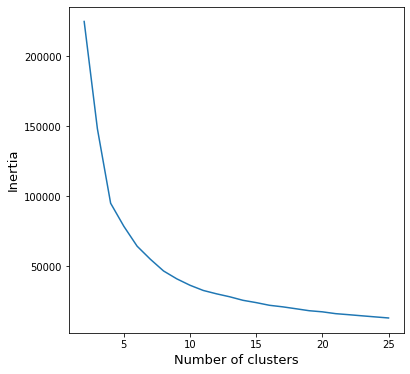

In [16]:
fig = plt.subplots(figsize=(6,6))

plt.plot(inertias.keys(), inertias.values())
plt.xlabel('Number of clusters', fontsize=13)
plt.ylabel('Inertia', fontsize=13)

## Visualise clusters of accidents on a map of the UK

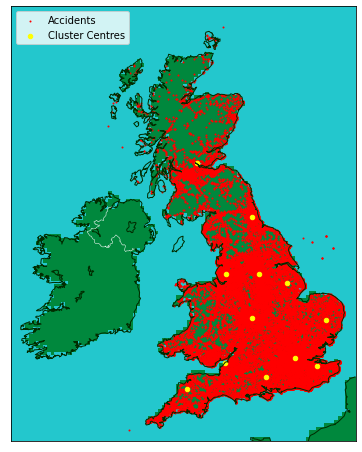

In [37]:
km = KMeans(n_clusters=8)
centers = km.fit(coords).cluster_centers_
centers = list(zip(*centers))


fig = plt.figure(figsize=(8, 8))
m = Basemap(llcrnrlon=-10.5,llcrnrlat=49.5,urcrnrlon=3.5,urcrnrlat=59.5,
            resolution='i',projection='tmerc',lon_0=-4.36,lat_0=54.7)
m.drawcoastlines(color='#012C00')
m.drawcountries(color='white')
m.drawlsmask(land_color='#00883D', ocean_color='#23C7CD',lakes=True)

m.scatter(accidents.longitude, accidents.latitude,
          latlon=True,
          alpha=1,
          s=1,
          color='red',
          marker='o',
          label='Accidents')

m.scatter(centers[0], centers[1],
          latlon=True,
          alpha=1,
          s=20,
          color='yellow',
          marker='o',
          label='Cluster Centres')

plt.legend(loc='upper left')

fig.savefig(plots_dir / 'accident_clusters')

## Clustering on weather conditions and speed limit

In [19]:
## merging all three datasets

# merging the accidents and vehicles datasets
accidents_vehicles = pd.merge(accidents, vehicles, on='accident_index')
# merging with the casualties dataset
avc = pd.merge(accidents_vehicles, casualties, on='accident_index')

In [20]:
def clusterer(df, x_col, y_col, n_clusters=5):
    """
    A simple function to reduce repeated code.
    Takes the dataset, an x and y feature and number of clusters
    and clusters (x, y) using k-means
    """
    df = df.filter([x_col, y_col])
    
    km = KMeans(n_clusters = n_clusters)
    
    centers = list(zip(*km.fit(df).cluster_centers_))
    
    plt.subplots(figsize=(4, 4))
    
    plt.scatter(df[x_col], df[y_col], s=0.2)
    plt.scatter(centers[0], centers[1])
    plt.ylabel(y_col, fontsize=13)
    plt.xlabel(x_col, fontsize=13)
    plt.xticks(range(1, 10))
    
    plt.show()

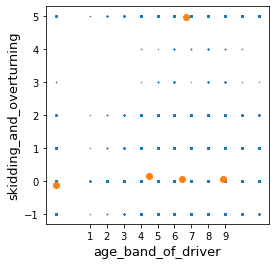

In [21]:
# clustering on age band of the driver and overturning
clusterer(avc, 'age_band_of_driver', 'skidding_and_overturning')

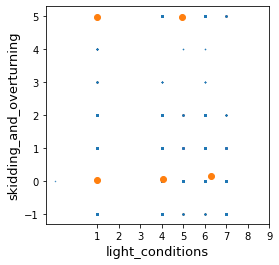

In [22]:
# clustering on light conditions and skidding and overturning
clusterer(avc, 'light_conditions', 'skidding_and_overturning')

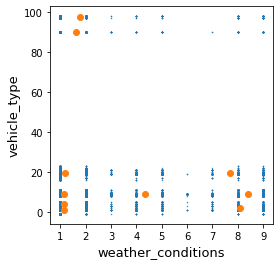

In [23]:
# clustering on weather conditions and vehicle type
clusterer(avc, 'weather_conditions', 'vehicle_type', 10)

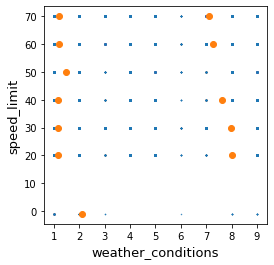

In [31]:
# clustering on weather conditions and speed limit
clusterer(avc, 'weather_conditions', 'speed_limit', 12)